In [2]:
import os
import re
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
working_dir = "/om2/user/ckauf/.result_caching/neural_nlp.models.wrapper.core.ActivationsExtractorHelper._from_sentences_stored"

In [4]:
def get_last_layer(model_identifier):
    """
    input: model_identifier of model of which we want to find the last layer
    output: last layer identifier
    """
    for ind,filename in enumerate(os.listdir(working_dir)):
        model_name = filename.split(",")[0]
        if "identifier=" + model_identifier == model_name:
            file = os.path.join(working_dir,filename)
            with open(file, 'rb') as f:
                result = pickle.load(f)
            result = result['data']
            layer_list = np.unique(result.layer)
            #order double-digit layers at end of list
            double_digits = []
            if model_identifier in ['distilgpt2','gpt2']:
                double_digits = [elm for elm in layer_list if 'encoder.h.' in elm and len(elm.split('.h.')[-1]) > 1]
            if model_identifier == 'albert-xxlarge-v2':
                double_digits = [elm for elm in layer_list if 'encoder.albert_layer_groups.' in elm and len(elm.split('.albert_layer_groups.')[-1]) > 1]
            layers = [e for e in layer_list if e not in double_digits] + double_digits
            final_layer = layers[-1]
            return final_layer
            break

In [5]:
def get_all_layers(model_identifier):
    """
    input: model_identifier of model of which we want to find the layers
    output: np.array of all unique layer identifiers, ordered by position
    """
    for ind,filename in enumerate(os.listdir(working_dir)):
        if "identifier=" + model_identifier in filename:
            file = os.path.join(working_dir,filename)
            with open(file, 'rb') as f:
                result = pickle.load(f)
            result = result['data']
            layer_list = np.unique(result.layer)
            #order double-digit layers at end of list
            double_digits = []
            if model_identifier in ['gpt2','distilgpt2']:
                double_digits = [elm for elm in layer_list if 'encoder.h.' in elm and len(elm.split('.h.')[-1]) > 1]
            if model_identifier == 'albert-xxlarge-v2':
                double_digits = [elm for elm in layer_list if 'encoder.albert_layer_groups.' in elm and len(elm.split('.albert_layer_groups.')[-1]) > 1]
            layers = [e for e in layer_list if e not in double_digits] + double_digits
            return layers
            break

In [6]:
def get_passage_identifier(filename):
    """
    get passage identifier to be used as key for the dictionary.
    important step: fill the identifier with 0s for single-digit passage numbers
    """
    passage = filename.split(",")[-1].split("-")[-1].split(".")[0]
    number = passage.split("sentences")[-1]
    if len(number) == 1:
        passage_identifier = passage[:-1] + number.zfill(2)
    else:
        passage_identifier = passage
    return passage_identifier

In [7]:
def get_dictionary(model_identifier, layer_identifier=None):
    """
    input: model identifier
    output: populated model dictionary with data of just the selected layer
    dictionary structure: passage_identifier --> condition identifier --> data
    """
    model_dictionary = model_identifier + "_dict"
    model_dictionary = {}
    
    #look at last layer by default
    if layer_identifier == None:
        layer_identifier = get_last_layer(model_identifier)
    else:
        layer_identifier = layer_identifier
    print("This is the layer I'm looking at: ", layer_identifier)
    
    for filename in tqdm(os.listdir(working_dir)):
        model_name = filename.split(",")[0]
        if "identifier=" + model_identifier == model_name:
            passage_identifier = get_passage_identifier(filename)
            condition = filename.split(",")[-1].split("-")[-2]
        
            file = os.path.join(working_dir,filename)
            with open(file, 'rb') as f:
                out = pickle.load(f)
            result = out['data']
            data = result[{"neuroid": [layer == layer_identifier for layer in result["layer"].values]}]
        
            if not passage_identifier in model_dictionary:
                model_dictionary[passage_identifier] = {}
            model_dictionary[passage_identifier][condition] = data
    
    return model_dictionary

In [8]:
def get_arrays(dictionary):
    #sort dictionary by passage identifier
    sorted_dict = dict(sorted(dictionary.items()))
    #create empty arrays
    #original,scr1,scr3,scr5,scr7,lowpmi,backward,random = ([] for i in range(8))
    original,scr1,scr3,scr5,scr7,lowpmi,random = ([] for i in range(7))
    #
    for key, value in sorted_dict.items(): #key is passage, value is dic from cond to xarray data
        original.append(value['Original'].values)
        scr1.append(value['Scr1'].values)
        scr3.append(value['Scr3'].values)
        scr5.append(value['Scr5'].values)
        scr7.append(value['Scr7'].values)
        lowpmi.append(value['lowPMI'].values)
        #backward.append(value['backward'].values)
        random.append(value['random'].values)
        
    #print(np.shape(original))
    return original,scr1,scr3,scr5,scr7,lowpmi,random #backward,random

In [9]:
def flatten_array(liste):
    liste_flatten = [item for sublist in liste for item in sublist]
    return liste_flatten

In [10]:
#def prepare_dataframe(original,scr1,scr3,scr5,scr7,lowpmi,backward,random,flatten=True):
def prepare_dataframe(original,scr1,scr3,scr5,scr7,lowpmi,random,flatten=True):
    
    if flatten:
        df = pd.DataFrame(data={'Original':np.asarray(flatten_array(original)).flatten(),
                             'Scr1':np.asarray(flatten_array(scr1)).flatten(),
                              'Scr3':np.asarray(flatten_array(scr3)).flatten(),
                              'Scr5':np.asarray(flatten_array(scr5)).flatten(),
                              'Scr7':np.asarray(flatten_array(scr7)).flatten(),
                              'lowpmi':np.asarray(flatten_array(lowpmi)).flatten(),
                              #'backward':np.asarray(flatten_array(backward)).flatten(),
                              'random':np.asarray(flatten_array(random)).flatten()})
    if not flatten:
        # print(np.shape(np.asarray(flatten_array(random))))
        df = {}
        df = {'Original':flatten_array(original),
                             'Scr1':flatten_array(scr1),
                              'Scr3':flatten_array(scr3),
                              'Scr5':flatten_array(scr5),
                              'Scr7':flatten_array(scr7),
                              'lowpmi':flatten_array(lowpmi),
                              #'backward':flatten_array(backward),
                              'random':flatten_array(random)}
    return df

In [11]:
def main_df_for_plotting(model_identifier, layer_identifier=None, flatten=True):
    model_dict = get_dictionary(model_identifier, layer_identifier)
    df = prepare_dataframe(*get_arrays(model_dict), flatten=flatten) #*flattens the tuple
    return df

In [12]:
def get_activation_dfs_for_all_layers(model_identifier, flatten=True):
    """
    input: model_identifier, whether to flatten (i.e. all sentence reps in one vector or leave 627*hidden size)
    output: dictionary: layer --> dataframe (conditions as column names, column values are flattened or unflattened activations)
    """
    layers = get_all_layers(model_identifier)
    df_dict = {}
    for ind,elm in enumerate(layers):
        df_dict[elm] = main_df_for_plotting(model_identifier,layer_identifier=elm,flatten=flatten)
    return df_dict

In [13]:
distilgpt2_correlation_dict = get_activation_dfs_for_all_layers("distilgpt2")

 25%|██▍       | 1856/7560 [00:00<00:00, 11172.15it/s]

This is the layer I'm looking at:  drop


 25%|██▍       | 1858/7560 [00:00<00:00, 17691.42it/s]

This is the layer I'm looking at:  encoder.h.0


 25%|██▍       | 1858/7560 [00:00<00:00, 18414.20it/s]

This is the layer I'm looking at:  encoder.h.1


 25%|██▍       | 1859/7560 [00:00<00:00, 17262.76it/s]

This is the layer I'm looking at:  encoder.h.2


 25%|██▍       | 1858/7560 [00:00<00:00, 18349.77it/s]

This is the layer I'm looking at:  encoder.h.3


 25%|██▍       | 1858/7560 [00:00<00:00, 18484.39it/s]

This is the layer I'm looking at:  encoder.h.4


 25%|██▍       | 1858/7560 [00:00<00:00, 18323.45it/s]

This is the layer I'm looking at:  encoder.h.5


100%|██████████| 7560/7560 [00:13<00:00, 548.01it/s]  


In [14]:
print(distilgpt2_correlation_dict.keys())

dict_keys(['drop', 'encoder.h.0', 'encoder.h.1', 'encoder.h.2', 'encoder.h.3', 'encoder.h.4', 'encoder.h.5'])


In [15]:
print(distilgpt2_correlation_dict['drop'].shape)

(481536, 7)


In [16]:
orig_column = distilgpt2_correlation_dict['drop']['Original']
conditions = list(distilgpt2_correlation_dict['drop'].columns)

for elm in conditions:
    correlation = orig_column.corr(distilgpt2_correlation_dict['drop'][elm])
    print(elm, correlation)

print("\n")
correlations = [orig_column.corr(distilgpt2_correlation_dict['drop'][elm]) for elm in conditions]
print(correlations)

Original 0.9999999999999999
Scr1 0.9679058004422257
Scr3 0.8864662294050848
Scr5 0.8432295883930693
Scr7 0.8158436388696593
lowpmi 0.8159095183618811
random 0.6127739882677191


[0.9999999999999999, 0.9679058004422257, 0.8864662294050848, 0.8432295883930693, 0.8158436388696593, 0.8159095183618811, 0.6127739882677191]


([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

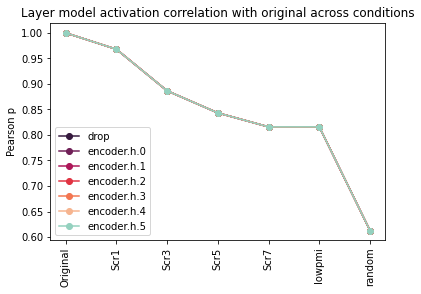

In [17]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
layers = get_all_layers("distilgpt2")
line_colors = sns.color_palette("rocket") + sns.color_palette("GnBu_d")
    
x = conditions
counter = 0
for key,value in distilgpt2_correlation_dict.items():
    ax.plot(x,correlations, '-o',color=line_colors[counter])
    counter += 1

    #conditions = list(distilgpt2_score_dict.keys())

ax.set_title('Layer model activation correlation with original across conditions')
ax.legend(layers)
ax.yaxis.set_label_text('Pearson p')
plt.xticks(rotation= 90)

In [18]:
def get_correlations_df_dict(model_identifier): #maybe pass activations dict as input so it doesn't have to recompute
    layers = get_all_layers(model_identifier)
    activations_dict = get_activation_dfs_for_all_layers(model_identifier)
    
    conditions = list(activations_dict[layers[0]].columns)
    
    correlations_df_dict = {}
    for layer in layers:
        orig_column = activations_dict[layer]['Original']
        correlations = [orig_column.corr(activations_dict[layer][elm]) for elm in conditions]
        correlations_df_dict[layer] = correlations
    
    return layers, conditions, correlations_df_dict

In [19]:
layers, conditions, distilgpt2_corr_dict = get_correlations_df_dict("distilgpt2")

 25%|██▍       | 1859/7560 [00:00<00:00, 17232.89it/s]

This is the layer I'm looking at:  drop


 25%|██▍       | 1859/7560 [00:00<00:00, 17118.63it/s]

This is the layer I'm looking at:  encoder.h.0


 25%|██▍       | 1859/7560 [00:00<00:00, 17124.16it/s]

This is the layer I'm looking at:  encoder.h.1


 25%|██▍       | 1858/7560 [00:00<00:00, 18536.18it/s]

This is the layer I'm looking at:  encoder.h.2


 25%|██▍       | 1859/7560 [00:00<00:00, 17143.06it/s]

This is the layer I'm looking at:  encoder.h.3


 25%|██▍       | 1859/7560 [00:00<00:00, 16983.50it/s]

This is the layer I'm looking at:  encoder.h.4


 25%|██▍       | 1858/7560 [00:00<00:00, 18219.52it/s]

This is the layer I'm looking at:  encoder.h.5


100%|██████████| 7560/7560 [00:13<00:00, 566.75it/s]  


In [20]:
def plot_correlations_lineplot(model_identifier, layers, conditions, correlations_dict):
    fig, ax = plt.subplots()
    line_colors = sns.color_palette("rocket") + sns.color_palette("GnBu_d") + [sns.color_palette("PRGn", 10)[2]] + [sns.color_palette("PuOr", 10)[0]]
    
    layers = layers
    conditions = conditions
    
    counter = 0
    for key,value in correlations_dict.items():
        ax.plot(conditions,value, '-o',color=line_colors[counter])
        counter += 1

    ax.set_title('Layer model activation correlation with model activations for unscrambled sentence across conditions')
    ax.legend(layers)
    ax.yaxis.set_label_text('Pearson p')
    plt.xticks(rotation= 90)

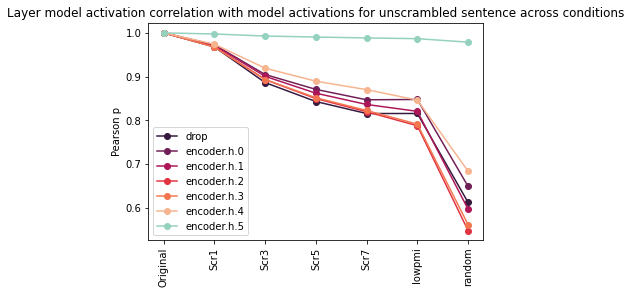

In [21]:
plot_correlations_lineplot("distilgpt2", layers, conditions, distilgpt2_corr_dict)

In [22]:
lm1b_layers, lm1b_conditions, lm1b_corr_dict = get_correlations_df_dict("lm_1b")

 80%|████████  | 6058/7560 [00:00<00:00, 56552.37it/s]

This is the layer I'm looking at:  lstm/lstm_0/control_dependency


 80%|████████  | 6060/7560 [00:00<00:00, 57355.74it/s]

This is the layer I'm looking at:  lstm/lstm_1/control_dependency


100%|██████████| 7560/7560 [00:11<00:00, 667.89it/s]  


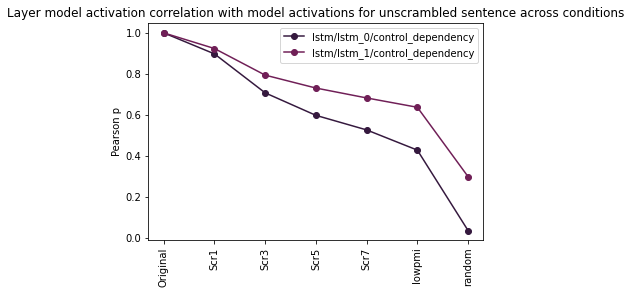

In [23]:
plot_correlations_lineplot("lm_1b", lm1b_layers, lm1b_conditions, lm1b_corr_dict)

In [24]:
gpt2_layers, gpt2_conditions, gpt2_corr_dict = get_correlations_df_dict("gpt2")

 60%|██████    | 4543/7560 [00:00<00:00, 42110.26it/s]

This is the layer I'm looking at:  drop


 60%|██████    | 4544/7560 [00:00<00:00, 42961.48it/s]

This is the layer I'm looking at:  encoder.h.0


 60%|██████    | 4544/7560 [00:00<00:00, 42520.68it/s]

This is the layer I'm looking at:  encoder.h.1


 60%|██████    | 4544/7560 [00:00<00:00, 43702.89it/s]

This is the layer I'm looking at:  encoder.h.2


 60%|██████    | 4544/7560 [00:00<00:00, 41694.56it/s]

This is the layer I'm looking at:  encoder.h.3


 60%|██████    | 4543/7560 [00:00<00:00, 26968.38it/s]

This is the layer I'm looking at:  encoder.h.4


 60%|██████    | 4544/7560 [00:00<00:00, 41811.92it/s]

This is the layer I'm looking at:  encoder.h.5


 60%|██████    | 4544/7560 [00:00<00:00, 41386.54it/s]

This is the layer I'm looking at:  encoder.h.6


 60%|██████    | 4544/7560 [00:00<00:00, 42984.54it/s]

This is the layer I'm looking at:  encoder.h.7


 60%|██████    | 4544/7560 [00:00<00:00, 41920.62it/s]

This is the layer I'm looking at:  encoder.h.8


 60%|██████    | 4544/7560 [00:00<00:00, 43267.93it/s]

This is the layer I'm looking at:  encoder.h.9


 60%|██████    | 4544/7560 [00:00<00:00, 42776.73it/s]

This is the layer I'm looking at:  encoder.h.10


 60%|██████    | 4544/7560 [00:00<00:00, 42745.75it/s]

This is the layer I'm looking at:  encoder.h.11


100%|██████████| 7560/7560 [00:19<00:00, 395.50it/s]  


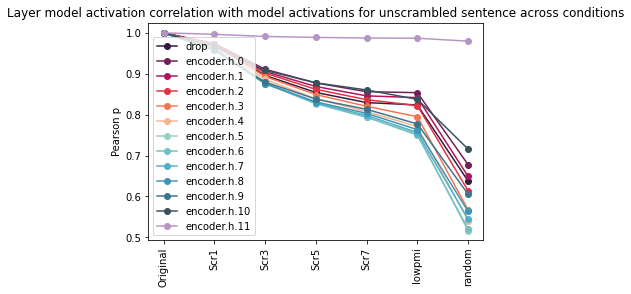

In [25]:
plot_correlations_lineplot("gpt2", gpt2_layers, gpt2_conditions, gpt2_corr_dict)

In [26]:
#albert_layers, albert_conditions, albert_corr_dict = get_correlations_df_dict('albert-xxlarge-v2')

In [27]:
#plot_correlations_lineplot('albert-xxlarge-v2', albert_layers, albert_conditions, albert_corr_dict)

In [28]:
import math
from matplotlib.gridspec import GridSpec

def get_corr_lineplots_loop(model_list):
    nsubplots = len(model_list)
    nrows = math.ceil(nsubplots/2)
    line_colors = sns.color_palette("rocket") + [sns.color_palette("PRGn", 10)[2]] + [sns.color_palette("PuOr", 10)[0]] + sns.color_palette("GnBu_d")
    
    fig2 = plt.figure(constrained_layout=True, figsize=(15, 5*nrows))
    fig2.suptitle('Layer model activation correlation with model activations for unscrambled sentence across conditions', fontsize=22, y=1.05)
    spec2 = GridSpec(ncols=2, nrows=nrows, figure=fig2)
    f2_ax = []
    
    model_counter = 0
    for i in range(nrows):
        for j in range(2):
            if model_counter + 1 > nsubplots:
                break
            else:
                layers, conditions, correlations_df_dict = get_correlations_df_dict(model_list[model_counter])
                f2_ax.append(fig2.add_subplot(spec2[i, j]))
                
                counter = 0
                for key,value in correlations_df_dict.items():
                    f2_ax[-1].plot(conditions,value, '-o',color=line_colors[counter])
                    counter += 1
                f2_ax[-1].set_title('{}'.format(model_list[model_counter]),fontsize=18)
                f2_ax[-1].yaxis.set_label_text('Pearson p')
                f2_ax[-1].legend(layers)
                plt.xticks(rotation= 90)
                model_counter += 1

 42%|████▏     | 3205/7560 [00:00<00:00, 29977.75it/s]

This is the layer I'm looking at:  projection


 80%|████████  | 6057/7560 [00:00<00:00, 42798.37it/s]

This is the layer I'm looking at:  lstm/lstm_0/control_dependency


 80%|████████  | 6060/7560 [00:00<00:00, 57122.30it/s]

This is the layer I'm looking at:  lstm/lstm_1/control_dependency


 25%|██▍       | 1859/7560 [00:00<00:00, 17028.20it/s]

This is the layer I'm looking at:  drop


 25%|██▍       | 1858/7560 [00:00<00:00, 18125.11it/s]

This is the layer I'm looking at:  encoder.h.0


 25%|██▍       | 1858/7560 [00:00<00:00, 18561.39it/s]

This is the layer I'm looking at:  encoder.h.1


 25%|██▍       | 1858/7560 [00:00<00:00, 17739.02it/s]

This is the layer I'm looking at:  encoder.h.2


 25%|██▍       | 1859/7560 [00:00<00:00, 17066.40it/s]

This is the layer I'm looking at:  encoder.h.3


 25%|██▍       | 1859/7560 [00:00<00:00, 16994.61it/s]

This is the layer I'm looking at:  encoder.h.4


 25%|██▍       | 1858/7560 [00:00<00:00, 18317.72it/s]

This is the layer I'm looking at:  encoder.h.5


 60%|██████    | 4544/7560 [00:00<00:00, 42174.70it/s]

This is the layer I'm looking at:  drop


 60%|██████    | 4544/7560 [00:00<00:00, 43799.00it/s]

This is the layer I'm looking at:  encoder.h.0


 60%|██████    | 4544/7560 [00:00<00:00, 42658.87it/s]

This is the layer I'm looking at:  encoder.h.1


 60%|██████    | 4544/7560 [00:00<00:00, 42866.21it/s]

This is the layer I'm looking at:  encoder.h.2


 60%|██████    | 4544/7560 [00:00<00:00, 42633.11it/s]

This is the layer I'm looking at:  encoder.h.3


 60%|██████    | 4544/7560 [00:00<00:00, 41110.96it/s]

This is the layer I'm looking at:  encoder.h.4


 60%|██████    | 4544/7560 [00:00<00:00, 43053.49it/s]

This is the layer I'm looking at:  encoder.h.5


 60%|██████    | 4544/7560 [00:00<00:00, 42738.94it/s]

This is the layer I'm looking at:  encoder.h.6


 60%|██████    | 4544/7560 [00:00<00:00, 42347.60it/s]

This is the layer I'm looking at:  encoder.h.7


 60%|██████    | 4544/7560 [00:00<00:00, 41420.27it/s]

This is the layer I'm looking at:  encoder.h.8


 60%|██████    | 4544/7560 [00:00<00:00, 41558.73it/s]

This is the layer I'm looking at:  encoder.h.9


 60%|██████    | 4544/7560 [00:00<00:00, 44276.11it/s]

This is the layer I'm looking at:  encoder.h.10


 60%|██████    | 4544/7560 [00:00<00:00, 42608.14it/s]

This is the layer I'm looking at:  encoder.h.11


100%|██████████| 7560/7560 [00:19<00:00, 393.84it/s]  


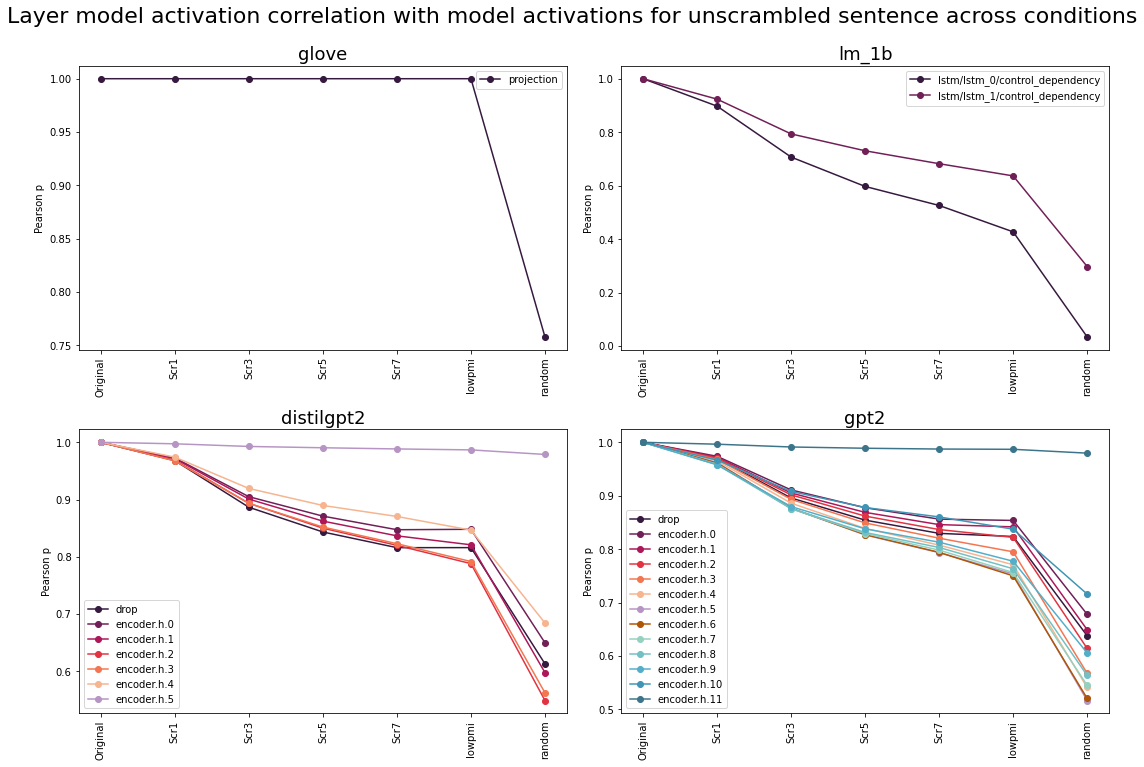

In [29]:
get_corr_lineplots_loop(['glove','lm_1b','distilgpt2', 'gpt2'])